### Error handling

First, we can add `try... except ...` block to handle errors within your Python functions that are called by your chain or represent graph nodes:

In [1]:
from enum import Enum
from langchain.output_parsers import EnumOutputParser
from langchain_google_vertexai import ChatVertexAI

class IsSuitableJobEnum(Enum):
    YES = "YES"
    NO = "NO"

parser = EnumOutputParser(enum=IsSuitableJobEnum)

prompt_template_enum = (
    "Given a job description, decide whether it suites a junior Java developer."
    "\nJOB DESCRIPTION:\n{job_description}\n\nAnswer only YES or NO."
)

job_description = "test job description"

llm = ChatVertexAI(model="gemini-2.0-flash-001")
analyze_chain = llm | parser

In [2]:
import logging
logger = logging.getLogger(__name__)

def analyze_job_description(state):
    try:
      prompt = prompt_template_enum.format(job_description=job_description)
      result = analyze_chain.invoke(prompt)
      return {"is_suitable": result}
    except Exception as e:
      logger.error(f"Exception {e} occured while executing analyze_job_description")
      return {"is_suitable": False}

Let's create a fake LLM to test our chain:

In [3]:
from langchain_core.language_models import GenericFakeChatModel
from langchain_core.messages import AIMessage

class MessagesIterator:

    def __init__(self):
        self._count = 0

    def __iter__(self):
        return self

    def __next__(self):
        self._count += 1
        if self._count % 2 == 1:
            raise ValueError("Something went wrong")
        return AIMessage(content="YES")

fake_llm = GenericFakeChatModel(messages=MessagesIterator())

Let's reuse the graph from our previous notebook:

In [13]:
from typing_extensions import TypedDict
from typing import Annotated, Literal
from operator import add
from langgraph.graph import StateGraph, START, END

class JobApplicationState(TypedDict):
    job_description: str
    is_suitable: bool
    application: str
    actions: Annotated[list[str], add]

def generate_application(state):
    print("...generating application...")
    return {"application": "some_fake_application", "actions": ["action2"]}

def is_suitable_condition(state: StateGraph) -> Literal["generate_application", END]:
    if state.get("is_suitable"):
        return "generate_application"
    return END

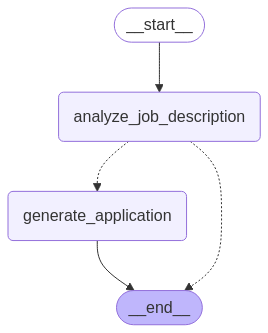

In [16]:
from langchain_core.runnables.config import RunnableConfig

llms = {
    "fake": fake_llm,
    "Google": llm
}

def analyze_job_description(state, config: RunnableConfig):
    try:
      print("here")
      llm = config["configurable"].get("model_provider", "Google")
      analyze_chain = llm | parser
      prompt = prompt_template_enum.format(job_description=job_description)
      result = analyze_chain.invoke(prompt)
      return {"is_suitable": result}
    except Exception as e:
      logger.error(f"Exception {e} occured while executing analyze_job_description")
      return {"is_suitable": False}

builder = StateGraph(JobApplicationState)
builder.add_node("analyze_job_description", analyze_job_description)
builder.add_node("generate_application", generate_application)
builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges(
    "analyze_job_description", is_suitable_condition)
builder.add_edge("generate_application", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
res = graph.invoke({"job_description":"fake_jd"}, config={"configurable": {"model_provider": "fake"}})
print(res)

Exception Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'str'> occured while executing analyze_job_description


here
{'job_description': 'fake_jd', 'is_suitable': False, 'actions': []}


In [18]:
analyze_chain_fake = fake_llm | parser

fake_llm_retry = fake_llm.with_retry(
    retry_if_exception_type=(ValueError,),
    wait_exponential_jitter=True,
    stop_after_attempt=2,
)
analyze_chain_fake_retries = fake_llm_retry | parser

In [19]:
analyze_chain_fake_retries = (fake_llm | parser).with_retry(
    retry_if_exception_type=(ValueError,),
    wait_exponential_jitter=True,
    stop_after_attempt=2,
)

In [20]:
analyze_chain_fake_retries.invoke("test")

<IsSuitableJobEnum.YES: 'YES'>

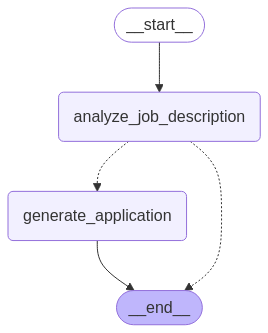

In [24]:
from langgraph.pregel import RetryPolicy

def analyze_job_description(state, config: RunnableConfig):
    model_provider = config["configurable"].get("model_provider", "Google")
    llm = llms[model_provider]
    analyze_chain = llm | parser
    prompt = prompt_template_enum.format(job_description=job_description)
    result = analyze_chain.invoke(prompt)
    return {"is_suitable": result}

builder = StateGraph(JobApplicationState)
builder.add_node("analyze_job_description", analyze_job_description, retry=RetryPolicy(retry_on=ValueError, max_attempts=2))
builder.add_node("generate_application", generate_application)
builder.add_edge(START, "analyze_job_description")
builder.add_conditional_edges(
    "analyze_job_description", is_suitable_condition)
builder.add_edge("generate_application", END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
res = graph.invoke({"job_description": job_description}, config={"configurable": {"model_provider": "fake"}})
print(res)

...generating application...
{'job_description': 'test job description', 'is_suitable': <IsSuitableJobEnum.YES: 'YES'>, 'application': 'some_fake_application', 'actions': ['action2']}


In [26]:
res = graph.invoke({"job_description":"fake_jd"}, config={"configurable": {"model_provider": "fake"}})
print(res)

...generating application...
{'job_description': 'fake_jd', 'is_suitable': <IsSuitableJobEnum.YES: 'YES'>, 'application': 'some_fake_application', 'actions': ['action2']}


In [31]:
fake_llm.invoke("test")

AIMessage(content='YES', additional_kwargs={}, response_metadata={}, id='run-bd9366c1-6ffe-400d-97e5-cfb9441176b2-0')

In [32]:
from langchain_core.runnables import RunnableLambda

chain_fallback = RunnableLambda(lambda _: print("running fallback"))
chain = fake_llm | RunnableLambda(lambda _: print("running main chain"))
chain_with_fb = chain.with_fallbacks([chain_fallback])

chain_with_fb.invoke("test")
chain_with_fb.invoke("test")

running fallback
running main chain
